In [15]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import ast
import datetime
import utils

We will analyse if the award receive or not have an influence on the difference between IMDB rating and metascore.

In [8]:
movies = pd.read_csv('data/processed/cmu_movies_augmented.csv')

one_hot_awards = pd.read_csv('data/processed/wikidata_awards_count.csv')

In [28]:
#we need to add the column rating_difference in movies 
movies['rating_difference'] = movies['metascore'] - movies['imdb_rating']*10

#we add a column award and nomination. The column is true if the movie has at least one award or nomination
movies['nomination'] = np.where(movies['count_nomination'] > 0, True, False)
movies['award'] = np.where(movies['count_award'] > 0, True, False)

In [29]:
#We will use one_hot_award and movie to create a new dataframe movies_awards by joining both dataframes

columns_one_hot = one_hot_awards.columns.tolist()[1:]

#join movies and one_hot_awards
movies_awards = movies.join(one_hot_awards.set_index('freebase_id'), on='freebase_id')

#replace nan by 0 for columns_one_hot
movies_awards[columns_one_hot] = movies_awards[columns_one_hot].fillna(0)

#transform columns_one_hot name in lower case and replace space by _
columns_one_hot_ = []
for column in columns_one_hot:
    columns_one_hot_.append(column.lower().replace(' ', '_').replace("'", ""))

#change the name of columns in movies_awards
movies_awards.columns = movies_awards.columns.str.lower().str.replace(' ', '_').str.replace("'", "")

In [30]:
#For future analysis, we need an explode version of movies_awards
movies_awards['awards_received'] = movies_awards.apply(lambda row: list(row[columns_one_hot_][row[columns_one_hot_] > 0].index), axis=1)

movies_awards_explode = movies_awards.explode('awards_received')
movies_awards_explode['awards_received'] = movies_awards_explode['awards_received'].fillna("no_award")

First, we can have a quick look at the influence of awards on metascore and IMDB rating

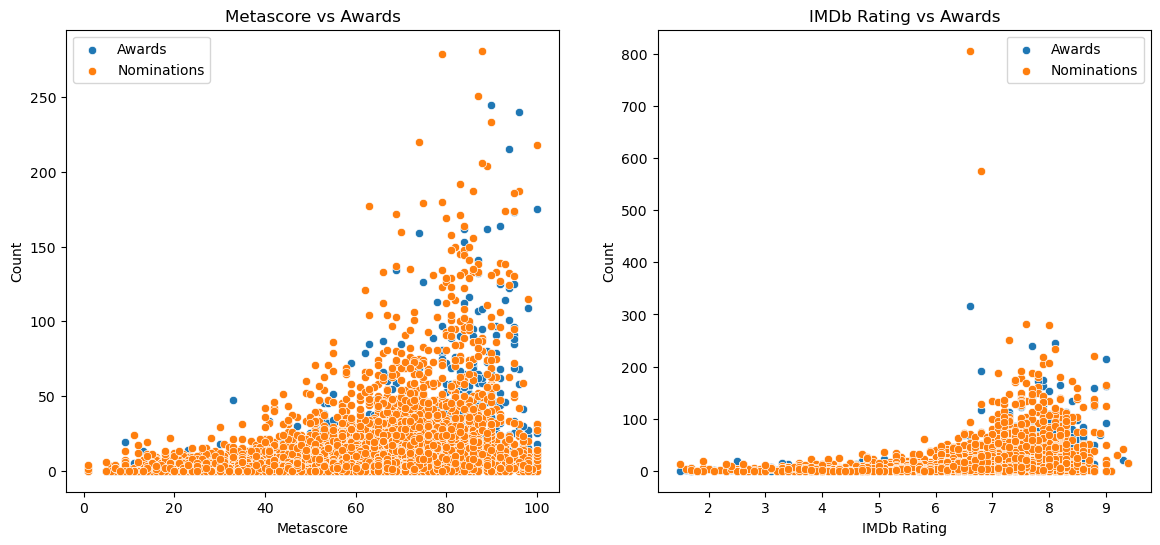

In [31]:
#We define a 2 subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot metascore vs nb awards in ax1
sns.scatterplot(x="metascore", y="count_award", data=movies, ax=ax1)
sns.scatterplot(x="metascore", y="count_nomination", data=movies, ax=ax1)
ax1.set_title("Metascore vs Awards")
ax1.set_ylabel("Count")
ax1.set_xlabel("Metascore")
ax1.legend(['Awards', 'Nominations'])


# Plot IMDb ratings vs nb awards in ax2
sns.scatterplot(x="imdb_rating", y="count_award", data=movies, ax=ax2)
sns.scatterplot(x="imdb_rating", y="count_nomination", data=movies, ax=ax2)
ax2.set_title("IMDb Rating vs Awards")
ax2.set_ylabel("Count")
ax2.set_xlabel("IMDb Rating")
ax2.legend(['Awards', 'Nominations'])

With the visual analysis, we see than the metascore and the IMDb rating is bigger when film have awards or awards nomination. We can confirm the trend with a linear regression.


In [ ]:
#perform the linear regression

ANALYSIS OF LINEAR REGRESSION

We can know focus on the difference of imdb rating and metascore

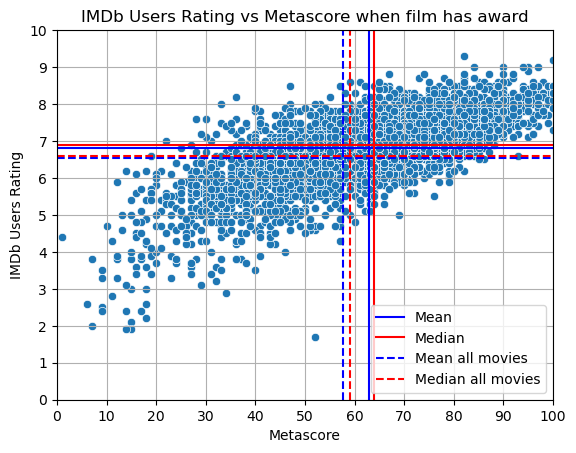

In [37]:
#scatter plot of metascore vs imdb_rating if award is true
movie_with_award = movies_awards[movies_awards['award'] == True]
sns.scatterplot(x="metascore", y="imdb_rating", data=movie_with_award)

# plot mean lines
plt.axhline(y=movie_with_award['imdb_rating'].mean(), color='b', linestyle='-')
plt.axvline(x=movie_with_award['metascore'].mean(), color='b', linestyle='-')

#plot mean line of all movies
plt.axhline(y=movies_awards['imdb_rating'].mean(), color='b', linestyle='--')
plt.axvline(x=movies_awards['metascore'].mean(), color='b', linestyle='--')

# plot median lines
plt.axhline(y=movie_with_award['imdb_rating'].median(), color='r', linestyle='-')
plt.axvline(x=movie_with_award['metascore'].median(), color='r', linestyle='-')

#plot median line of all movies
plt.axhline(y=movies_awards['imdb_rating'].median(), color='r', linestyle='--')
plt.axvline(x=movies_awards['metascore'].median(), color='r', linestyle='--')

# legend the lines but not the scatter plots
import matplotlib.lines as mlines
blue_line = mlines.Line2D([], [], color='blue', label='Mean')
blue_line_ = mlines.Line2D([], [], color='blue', label='Mean all movies', linestyle='--')
red_line = mlines.Line2D([], [], color='red', label='Median')
red_line_ = mlines.Line2D([], [], color='red', label='Median all movies', linestyle='--')
plt.legend(handles=[blue_line, red_line, blue_line_, red_line_])

plt.title("IMDb Users Rating vs Metascore when film has award")
plt.xticks(range(0, 101, 10))
plt.yticks(range(0, 11, 1))
plt.xlim(0, 100)
plt.ylim(0, 10)
plt.xlabel("Metascore")
plt.ylabel("IMDb Users Rating")
plt.grid()

In [52]:
#Perform OLS for the rating difference vs awards 

model = smf.ols(formula='rating_difference ~ award', data=movies)

results = model.fit()

print(results.summary())

df_results = pd.DataFrame(results.params)
df_results['p-value'] = results.pvalues
df_results['lower-ci'] = results.conf_int()[0]
df_results['upper-ci'] = results.conf_int()[1]

#drop line Intercept
df_results = df_results.drop('Intercept')

display(df_results)

                            OLS Regression Results                            
Dep. Variable:      rating_difference   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     722.9
Date:                Fri, 15 Dec 2023   Prob (F-statistic):          2.45e-152
Time:                        17:23:12   Log-Likelihood:                -30424.
No. Observations:                7770   AIC:                         6.085e+04
Df Residuals:                    7768   BIC:                         6.087e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -13.2304      0.237    -55.781

,0,p-value,lower-ci,upper-ci
award[T.True],7.834059,2.453387e-152,7.262903,8.405214


In [53]:
#Perform OLS for the rating difference vs nomination

model = smf.ols(formula='rating_difference ~ nomination', data=movies)

results = model.fit()

temp = pd.DataFrame(results.params)
temp['p-value'] = results.pvalues
temp['lower-ci'] = results.conf_int()[0]
temp['upper-ci'] = results.conf_int()[1]

#drop line Intercept
temp = temp.drop('Intercept')

#add temp to df_results
df_results = pd.concat([df_results, temp])

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      rating_difference   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     466.7
Date:                Fri, 15 Dec 2023   Prob (F-statistic):          1.49e-100
Time:                        17:23:15   Log-Likelihood:                -30543.
No. Observations:                7770   AIC:                         6.109e+04
Df Residuals:                    7768   BIC:                         6.110e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -13.3118      0

In [58]:
#rename column 0 to coef
df_results = df_results.rename(columns={0: 'coef'})
display(df_results)


,coef,p-value,lower-ci,upper-ci
award[T.True],7.834059,2.453387e-152,7.262903,8.405214
nomination[T.True],7.004585,1.489961e-100,6.368962,7.640208


<ErrorbarContainer object of 3 artists>

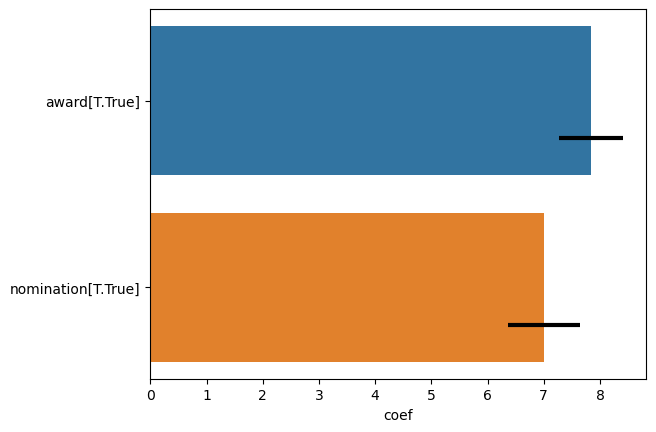

In [68]:
#bar plot of df_results with error bar
bar = sns.barplot(x='coef', y=df_results.index, data=df_results)

df_results['ci_error'] = df_results['upper-ci'] - df_results['coef']

y_positions = bar.get_yticks()

# Adjust positions based on the number of categories
adjusted_positions = y_positions + bar.patches[0].get_height() / len(df_results['coef']) / 2

plt.errorbar(x=df_results['coef'], y=adjusted_positions, 
                     xerr=[df_results['ci_error'], df_results['ci_error']], 
                     fmt='none', color='black', capsize=0, elinewidth=3, markeredgewidth=0)

From the plot and the 2 OLS, it's seems that having a award or a nomination reduce the difference between IMDB rating and metascore. 

We need to more focus on the type of awards receive by the movies to confirm this first analysis and check if the rating difference change with the type of award